# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
from sklearn.datasets import load_boston

In [9]:
boston = load_boston()

In [10]:
X = boston["data"]
y = boston["target"]

In [150]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [151]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.07898350242079

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__


Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [4]:
from sklearn.metrics import mean_squared_error
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ### your code here
    pred_matrix = np.full(shape=(X.shape[0], num_runs), fill_value=np.nan)
    
    for i in range(num_runs):
        bootstrap_indexes = np.random.randint(low=0, high=X.shape[0], size=X.shape[0])
        out_of_bag_indexes = np.setdiff1d(np.arange(X.shape[0]), bootstrap_indexes)
        regressor.fit(X[bootstrap_indexes], y[bootstrap_indexes])
        y_pred = regressor.predict(X[out_of_bag_indexes])
        pred_matrix[out_of_bag_indexes, i] = y_pred
        
    K = (~np.isnan(pred_matrix)).sum(axis=1)
    obj = K != 0
    aver_pred = np.nanmean(pred_matrix[obj], axis=1) 
    biase = np.mean(np.square(aver_pred - y[obj]))
    variance = np.mean(np.nanvar(pred_matrix[obj], axis=1))
    error = np.nanmean(np.square(pred_matrix.T - y[obj]))
    return biase, variance, error
        
    

__2. (0 баллов)__


Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate

In [154]:
print(tabulate([('LinearRegression', ) + compute_biase_variance(LinearRegression(), X, y), 
                ('DecisionTreeRegressor', ) + compute_biase_variance(DecisionTreeRegressor(), X, y),
                ('RandomForestRegressor', ) + compute_biase_variance(RandomForestRegressor(), X, y)
               ],
               headers=['Name of model', 'biase', 'variance', 'error'], tablefmt="grid"))

+-----------------------+---------+------------+---------+
| Name of model         |   biase |   variance |   error |
+=======================+=========+============+=========+
| LinearRegression      | 23.7218 |   0.914365 | 24.7314 |
+-----------------------+---------+------------+---------+
| DecisionTreeRegressor | 10.0324 |  12.9098   | 23.1336 |
+-----------------------+---------+------------+---------+
| RandomForestRegressor | 10.6196 |   2.23543  | 12.7885 |
+-----------------------+---------+------------+---------+


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ ВСЕ СУПЕР ЧЕТКО. Все согласается с теорией с лекции.

1. biase + variance ~= error ✅
2. Линейная регрессия как и полагается имеет кайне высокое смещение и супер низкий разброс. Так как переобучить линейную регрессию довольно сложно, поэтому большинство "линий" будут рядом.
3. Логично, решающее дерево легко переобучается (вообще без костылей, она почти всегда переобучается, монжо сказать, что всегда), поэтому и смещение будет пониже, но разброс будет также сильный, то есть дерео сильно подстраивается под обучающую выборку.
4. Рандом форест убивает недостатки дерева, поэтому разброс меньше.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

В хороших условиях усредненине с помощщью беггинга уменьшает разброс алгоритмов регрессии в n_estimators раз (кол-во бутстреп алгоритмов, обученных на выборках), если базовые алгоритмы мало коррелированы. По умолчанию n_estimators = 10. Но так как выборки строятся с помощью бутсрепа, то получается высокая корреляция, поэтому и такие результаты.

In [10]:
from sklearn.ensemble import BaggingRegressor

In [155]:
print(tabulate([
    ('BaggingLinearRegression', ) + compute_biase_variance(BaggingRegressor(LinearRegression()), X, y), 
    ('BaggingDecisionTreeRegressor', ) + compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y),
    ('BaggingRandomForestRegressor', ) + compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y)],
               headers=['Name of model', 'biase', 'variance', 'error'], tablefmt="grid"))

+------------------------------+---------+------------+---------+
| Name of model                |   biase |   variance |   error |
+==============================+=========+============+=========+
| BaggingLinearRegression      | 23.7208 |    1.03171 | 24.7469 |
+------------------------------+---------+------------+---------+
| BaggingDecisionTreeRegressor | 10.5607 |    3.37891 | 13.9498 |
+------------------------------+---------+------------+---------+
| BaggingRandomForestRegressor | 11.5902 |    1.37441 | 12.9298 |
+------------------------------+---------+------------+---------+


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [12]:
from sklearn.model_selection import train_test_split
from matplotlib import cm

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects/X.shape[0])
    
    plt.style.use('fivethirtyeight')
    plt.title(title, size=14)
    for i in range(num_runs):
        bootstrap_indexes = np.random.randint(low=0, high=X_train.shape[0], size=X_train.shape[0])
        regressor.fit(X_train[bootstrap_indexes], y_train[bootstrap_indexes])
        y_pred = regressor.predict(X_test)
        plt.scatter(np.arange(X_test.shape[0]), y_pred, s = 34,
                   color=cm.get_cmap("Paired")(np.linspace(0, 1, X_test.shape[0])))
        
    plt.scatter(np.arange(y_test.shape[0]), y_test, c='k', marker='D', s=41)
    plt.xticks(np.arange(10))
    plt.xlabel("Номер тестового объекта", size=10)
    plt.ylabel("Значение тестового объекта", size=10)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

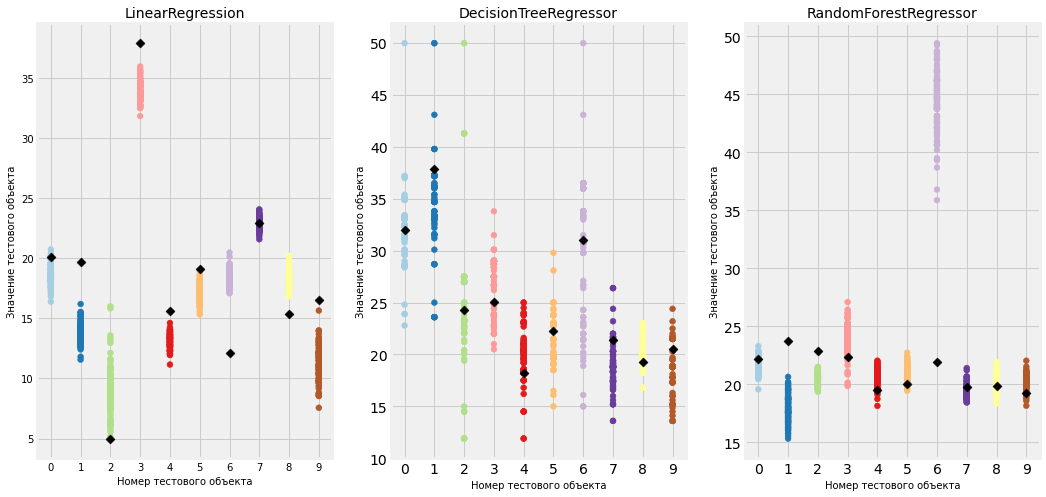

In [157]:
plt.figure(figsize=(16, 8))

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
titles = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor']
for i, regressor in enumerate(models):
    plt.subplot(1, 3, i + 1)
    plot_predictions(regressor, X, y, title=titles[i])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
1. Линейная регрессия.
Чем кучнее ответы, тем меньге разброс (variance). На графике очень хорошо видно, что все ответы сбились в кучку, но при усреднении, ответ будет находться далеко от истинного поэтому и смещение будет таким большим.
2. Решающее дерево как уже было сказано сильно переобучается, и как мы видим в итоге все ответы разбросаны, находится крайне далеко друг от друга иногда расстояние достигает более чем в 15 единиц между ответами двух разных деревьев, в то время как линейная регссия различия между ответами моделей максимум 5. Поэтоу и разброс такой большой. Но при усреднении все чики-пуки. Хоть и разброс крайне высокий, но смещение будет существенно ниже чем у линейной регрессии (истинный ответ находится между ответами моделей, пожтмоу при сложении и делении мы получим что между этими ответаи и это будет близко к истине.
3. Случайный лес убивает разброс дерева, ответы становятся "кучнее" и различия ответов разных моделей сильно уменшились. Видим, что иногда случайный лес промахивается, отсюда у нас и смещение, но при усреднении ответов мы не сильно далеко уходим от истинного результата.


### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

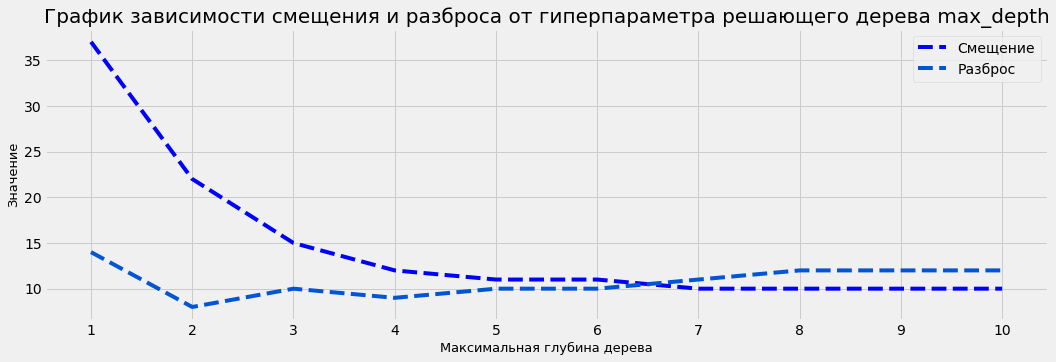

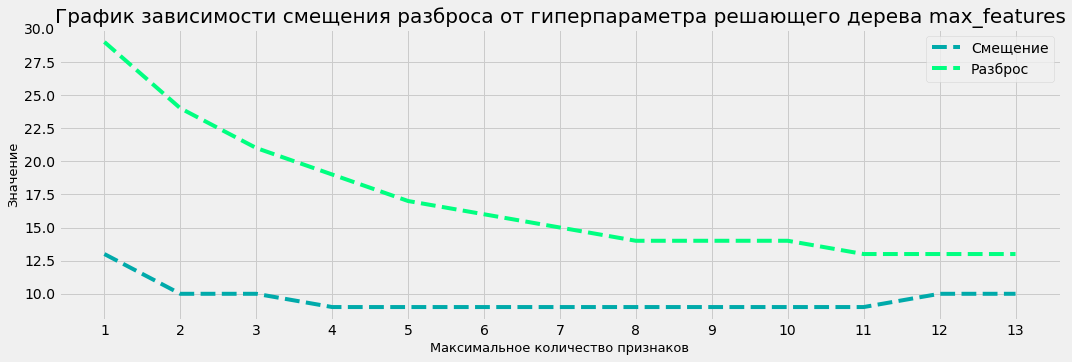

In [160]:
max_depth = 10
max_features= X.shape[1]
biases = np.arange(max_depth + max_features)
variances = np.arange(max_depth + max_features)
for i in range(max_depth):
    biases[i], variances[i], _ = compute_biase_variance(DecisionTreeRegressor(max_depth=i + 1), X, y)
for i in range(max_features):
    biases[i + max_depth], variances[i + max_depth], _ = compute_biase_variance(
        DecisionTreeRegressor(max_features=i+1), X, y)


cmap = cm.get_cmap("winter")(np.linspace(0, 1, 4))

### Первый график max_depth
plt.figure(figsize=(16, 5))
plt.title("График зависимости смещения и разброса от гиперпараметра решающего дерева max_depth", size=20)

plt.plot(np.arange(max_depth) + 1, biases[:max_depth], c=cmap[0], linestyle='--')

plt.plot(np.arange(max_depth) + 1, variances[:max_depth], c=cmap[1], linestyle='--')

plt.xlabel('Максимальная глубина дерева', size=13)
plt.ylabel('Значение', size=13)
plt.xticks(np.arange(max_depth) + 1)
plt.legend(['Смещение', 'Разброс'])

plt.show()


### Второй график max_features
plt.figure(figsize=(16, 5))
plt.title("График зависимости смещения разброса от гиперпараметра решающего дерева max_features", size=20)

plt.plot(np.arange(max_features) + 1, biases[max_depth:], c=cmap[2], linestyle='--')

plt.plot(np.arange(max_features) + 1, variances[max_depth:], c=cmap[3], linestyle='--')

plt.xlabel('Максимальное количество признаков', size=13)
plt.ylabel('Значение', size=13)
plt.xticks(np.arange(max_features) + 1)
plt.legend(['Смещение', 'Разброс'])

plt.show()
    

__9. (0 баллов)__


Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

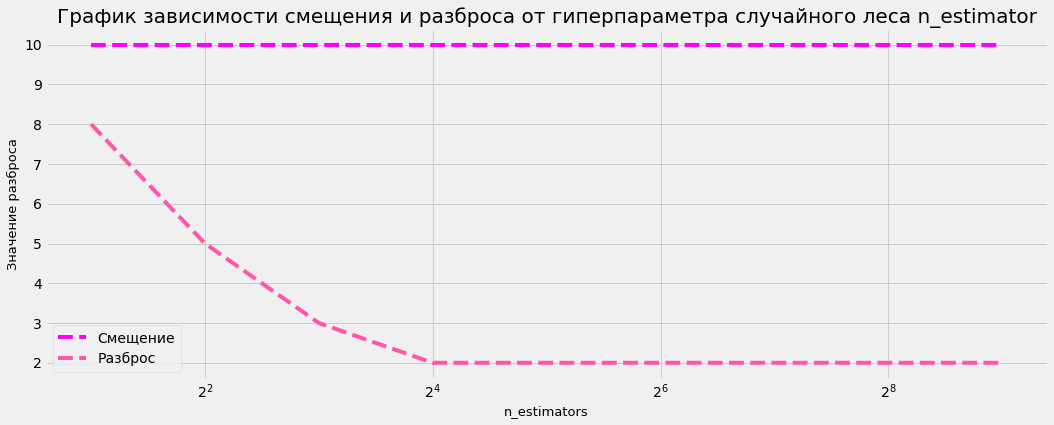

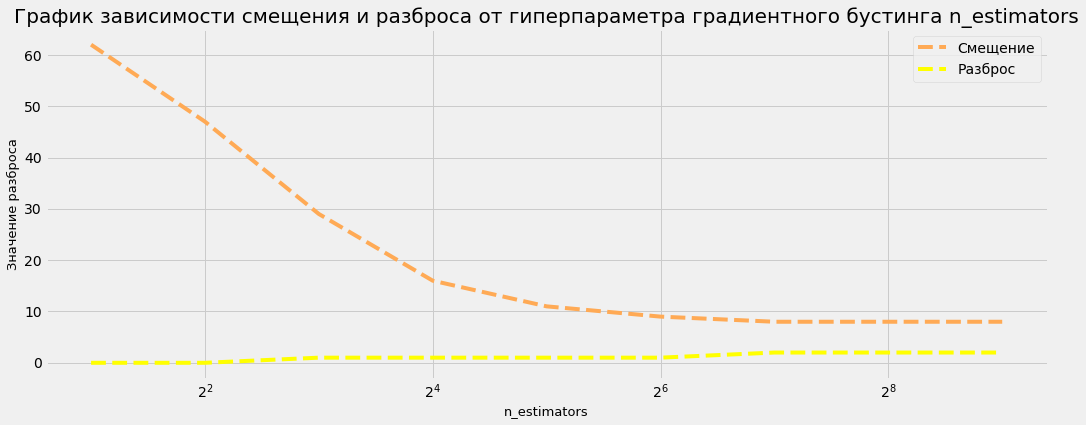

In [17]:
# from sklearn.ensemble import GradientBoostingRegressor

# n_estimators = 10
# biases = np.arange(2 * n_estimators)
# variances = np.arange(2 * n_estimators)

# for i in range(1, n_estimators):
#     biases[i], variances[i], _ = compute_biase_variance(RandomForestRegressor(n_estimators=2**i), X, y)
#     biases[i + n_estimators], variances[i + n_estimators], _ = compute_biase_variance(
#         GradientBoostingRegressor(n_estimators=2**i), X, y)


cmap = cm.get_cmap("spring")(np.linspace(0, 1, 4))
plt.style.use('fivethirtyeight')

### Превый график
plt.figure(figsize=(16, 6))
plt.title("График зависимости смещения и разброса от гиперпараметра случайного леса n_estimator", size=20)

plt.plot(2 ** np.arange(1, 10), biases[1:n_estimators], c=cmap[0], linestyle='--')

plt.plot(2 ** np.arange(1, 10), variances[1:n_estimators], c=cmap[1], linestyle='--')

plt.xlabel('n_estimators', size=13)
plt.ylabel('Значение разброса', size=13)
plt.xticks(np.arange(n_estimators) * 2 + 2)
plt.xscale('log', base=2)
plt.legend(['Смещение', 'Разброс'])
plt.show()


### Второй график
plt.figure(figsize=(16, 6))
plt.title("График зависимости смещения и разброса от гиперпараметра градиентного бустинга n_estimators", size=20)

plt.plot(2 ** np.arange(1, 10), biases[n_estimators + 1:], c=cmap[2], linestyle='--')

plt.plot(2 ** np.arange(1, 10), variances[n_estimators + 1:], c=cmap[3], linestyle='--')

plt.xlabel('n_estimators', size=13)
plt.ylabel('Значение разброса', size=13)
plt.xticks(np.arange(n_estimators) * 2 + 2)
plt.xscale('log', base=2)
plt.legend(['Смещение', 'Разброс'])
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

**На Первом графике** мы видим как сильно падает смещение с ростом глубины дерева, то есть дерево все лучше предсказывает при увелечении глубины увеличивается качество обучения или о в некотором смысле обобщаюащей способности алгоритма. То есть мы лучше учимся и логично, что лучше предсказываем в среднем, но как мы видим растет качество обучения и в какой-то момент мы начинаем переобучаться слегка и растет разброс. Мы чуть сильнее подстраиваемся под выборку, что приводит к маленькому увелечению разброса. Все те же причины и для **второго графика**.

**Третий график**. В общем, все сходится с теорий. Смещение у леса не меняется, но сильно падает разброс. Как и было задумано, исправить недостатки дерева (его разброс).

**Четвертый график**. В общем, градиент бустинг - ультра мощный алгоритм, пока что это лучший из того, что мы знаем. Его суть в том, что он обучается на ошибках прошлой модели, тем самый каждый раз уменьшает ошибка. То есть чем n_estimators, тем увеливается качество, уменьшается ошибка, растет обобщающая способность. Все как и говорили на лекции.